# Simulations TVA - Budget 2025 : Chapitre socio-fiscal

In [1]:
import numpy as np
import pandas as pd
import os
import csv
import ast
import seaborn as sns
from matplotlib import pyplot as plt
import wquantiles

from wquantiles import quantile
from openfisca_survey_manager.utils import asof

from openfisca_france_indirect_taxation import FranceIndirectTaxationTaxBenefitSystem
from openfisca_france_indirect_taxation.surveys import SurveyScenario
from openfisca_france_indirect_taxation.examples.utils_example import (
    dataframe_by_group,
    df_weighted_average_grouped)
from openfisca_france_indirect_taxation.build_survey_data.utils import weighted_sum
from openfisca_france_indirect_taxation.projects.TVA_Herve_IPP.new_calage_bdf_cn import new_get_inflators_by_year
from openfisca_france_indirect_taxation.projects.TVA_Herve_IPP.Utils import weighted_quantiles
from openfisca_france_indirect_taxation.utils import assets_directory, get_input_data_frame

In [3]:
simulated_variables = ['depenses_tva_taux_plein',
'depenses_tva_taux_intermediaire',
'depenses_tva_taux_reduit',
'depenses_tva_taux_super_reduit',
'depenses_ht_tva_taux_plein',
'depenses_ht_tva_taux_intermediaire',
'depenses_ht_tva_taux_reduit',
'depenses_ht_tva_taux_super_reduit',
'depenses_tva_exonere',
'depenses_totales',
'depenses_tot',
'tva_total',
'rev_disponible',
 'niveau_de_vie',
 'niveau_vie_decile',
 'ocde10',
 'pondmen',
 'nactifs',
 'npers',
 'identifiant_menage']

In [4]:
from openfisca_france_indirect_taxation.projects.TVA_Herve_IPP.Reform_TVA_budget_2025 import augmente_tous_les_taux

In [5]:
year = 2024
data_year = 2017
tax_benefit_system = FranceIndirectTaxationTaxBenefitSystem()
inflators_by_year = new_get_inflators_by_year(rebuild = False, year_range = range(2017, 2025), data_year = data_year)
inflation_kwargs = dict(inflator_by_variable = inflators_by_year[year])

survey_scenario = SurveyScenario.create(
    inflation_kwargs =  inflation_kwargs,
    baseline_tax_benefit_system = tax_benefit_system,
    reform = augmente_tous_les_taux,
    year = year,
    data_year = data_year
    )

## Recalage sur les niveaux de vie dans TaxIPP

In [6]:
data = {"quantile_indiv_niveau_vie": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    'rev_disponible_taxipp' : [
        17164,
        28523,
        32785,
        37962,
        42484,
        47179,
        53571,
        60538,
        72271,
        121762,
    ],
    'niveau_de_vie_taxipp' : [
        8082,
        14242,
        17617,
        20598,
        23339,
        26229,
        29506,
        33734,
        40382,
        69374
    ]
}
df_taxipp = pd.DataFrame(data)

In [7]:
df_taxipp

,quantile_indiv_niveau_vie,rev_disponible_taxipp,niveau_de_vie_taxipp
0,1,17164,8082
1,2,28523,14242
2,3,32785,17617
3,4,37962,20598
4,5,42484,23339
5,6,47179,26229
6,7,53571,29506
7,8,60538,33734
8,9,72271,40382
9,10,121762,69374


In [8]:
# On se place au niveau individu (en dupliquant les observations de chaque ménage) et on calcule des déciles de niveau de vie individuels

baseline_menage = survey_scenario.create_data_frame_by_entity(simulated_variables, filter_by = 'rev_disponible > 0', use_baseline = True, period = 2024)['menage']
baseline_indiv = baseline_menage.loc[baseline_menage.index.repeat(baseline_menage['npers'])]
baseline_indiv['quantile_indiv_niveau_vie'] = weighted_quantiles(baseline_indiv['niveau_de_vie'], labels = np.arange(1,11), weights = baseline_indiv['pondmen'], return_quantiles=False)
baseline_indiv['quantile_indiv_niveau_vie'] = baseline_indiv['quantile_indiv_niveau_vie'].astype(int)

df_decile_indiv = baseline_indiv[['identifiant_menage','quantile_indiv_niveau_vie']].drop_duplicates()

In [9]:
baseline_by_decile = df_weighted_average_grouped(dataframe = baseline_indiv, 
                                                   groupe = 'quantile_indiv_niveau_vie', 
                                                   varlist = ['rev_disponible','niveau_de_vie']
                                                    )

baseline_by_decile = baseline_by_decile.merge(df_taxipp, how = 'inner', on = 'quantile_indiv_niveau_vie')
baseline_by_decile['coeff_calage'] = baseline_by_decile['rev_disponible_taxipp'] / baseline_by_decile['rev_disponible']

In [10]:
baseline_by_decile

,quantile_indiv_niveau_vie,rev_disponible,niveau_de_vie,rev_disponible_taxipp,niveau_de_vie_taxipp,coeff_calage
0,1,25928.896074,13169.605807,17164,8082,0.661964
1,2,38386.813041,19881.068774,28523,14242,0.743042
2,3,43950.252978,24022.842824,32785,17617,0.745957
3,4,50662.486034,27726.100521,37962,20598,0.749312
4,5,56469.521240,31233.648930,42484,23339,0.752335
5,6,62927.754364,34895.352100,47179,26229,0.749733
6,7,70233.377372,38921.835167,53571,29506,0.762757
7,8,79162.744661,44181.255864,60538,33734,0.764728
8,9,93326.521397,52241.763156,72271,40382,0.774389
9,10,141622.511358,80573.514129,121762,69374,0.859764


In [11]:
input_data_frame = get_input_data_frame(2017)
input_data_frame = input_data_frame.merge(df_decile_indiv, how = 'left', on = 'identifiant_menage')
input_data_frame = input_data_frame.merge(baseline_by_decile[['quantile_indiv_niveau_vie','coeff_calage']], how = 'left', on = 'quantile_indiv_niveau_vie')
input_data_frame['rev_disponible'] = input_data_frame['rev_disponible'] * input_data_frame['coeff_calage']

## Recalage sur les 13 Milliards

On recale également les dépenses pour atteindre un montant de dépenses hors-taxes de 60,5% de 1 300 Milliards. De sorte que le rendement du point de TVA soit de 13 Milliards

In [13]:
depenses_ht_totales = (survey_scenario.compute_aggregate(variable = 'depenses_ht_tva_taux_plein', use_baseline= True, period = year) +
 survey_scenario.compute_aggregate(variable = 'depenses_ht_tva_taux_intermediaire', use_baseline= True, period = year) + 
 survey_scenario.compute_aggregate(variable = 'depenses_ht_tva_taux_reduit', use_baseline= True, period = year) + 
 survey_scenario.compute_aggregate(variable = 'depenses_ht_tva_taux_super_reduit', use_baseline= True, period = year)
 )
depenses_ht_totales
tva_total = survey_scenario.compute_aggregate(variable = 'tva_total', use_baseline= True, period = year)
emplois_taxables_tot = 13E11
part_conso_menages = 0.605
coeff = part_conso_menages * emplois_taxables_tot / depenses_ht_totales
coeff

0.8607480864846293

In [14]:
tva_total / depenses_ht_totales

0.13663706258635036

In [15]:
new_inflators_2024 = { k:v if k in ['loyer_impute','rev_disp_yc_loyerimpute','rev_disponible'] else  v*coeff 
                      for k,v in inflators_by_year[2024].items()}
inflation_kwargs = dict(inflator_by_variable = new_inflators_2024)

survey_scenario = SurveyScenario.create(
    input_data_frame = input_data_frame, # La base d'entrée a des revenus disponibles / niveaux de vie calés sur ceux de taxipp
    inflation_kwargs =  inflation_kwargs,
    baseline_tax_benefit_system = tax_benefit_system,
    reform = augmente_tous_les_taux,
    year = year,
    )

In [16]:
recolte_taux_plein = survey_scenario.compute_aggregate(variable='tva_taux_plein', filter_by = 'rev_disponible > 0', difference= True, period = year) * 1e-9
recolte_taux_inter = survey_scenario.compute_aggregate(variable='tva_taux_intermediaire', filter_by = 'rev_disponible > 0', difference= True, period = year) * 1e-9
recolte_taux_reduit = survey_scenario.compute_aggregate(variable='tva_taux_reduit', filter_by = 'rev_disponible > 0', difference= True, period = year) * 1e-9
recolte_taux_super_reduit = survey_scenario.compute_aggregate(variable='tva_taux_super_reduit', filter_by = 'rev_disponible > 0', difference= True, period = year) * 1e-9

In [17]:
recolte_taux_plein + recolte_taux_inter + recolte_taux_reduit + recolte_taux_super_reduit

7.849394042285157

In [18]:
survey_scenario.compute_aggregate(variable='tva_total', filter_by = 'rev_disponible > 0', use_baseline= True, period = year) * 1e-9

107.24413819412776

In [19]:
baseline_menage = survey_scenario.create_data_frame_by_entity(simulated_variables, filter_by = 'rev_disponible > 0', use_baseline = True, period = 2024)['menage']
reform_menage   = survey_scenario.create_data_frame_by_entity(simulated_variables, filter_by = 'rev_disponible > 0', use_baseline = False, period = 2024)['menage']

In [20]:
difference_menage = pd.DataFrame()
difference_menage['depenses_totales'] = baseline_menage['depenses_totales'] - reform_menage['depenses_totales']
difference_menage[['depenses_tot','rev_disponible','niveau_de_vie','niveau_vie_decile','ocde10','pondmen','nactifs','npers']] = baseline_menage[['depenses_tot','rev_disponible','niveau_de_vie','niveau_vie_decile','ocde10','pondmen','nactifs','npers']]
for taux in ['plein','intermediaire', 'reduit', 'super_reduit']:
    difference_menage['depenses_tva_taux_{}'.format(taux)] = baseline_menage['depenses_tva_taux_{}'.format(taux)] - reform_menage['depenses_tva_taux_{}'.format(taux)] 
difference_menage['actifs'] = (difference_menage['nactifs'] >= 1)

In [ ]:
#difference_menage['cinquantieme_niveau_vie'] = weighted_quantiles(difference_menage['niveau_de_vie'], labels = np.arange(1,51), weights = difference_menage['pondmen'], return_quantiles=False)

# perc_2 = difference_menage.loc[difference_menage['cinquantieme_niveau_vie'] == 1, :]
# list_var = perc_2.columns.tolist()
# list_var.remove('pondmen')
# average_perc_2 = df_weighted_average_grouped(perc_2,'actifs',list_var)
# average_perc_2['pondmen'] = perc_2.groupby(by = 'actifs')['pondmen'].sum()
# average_perc_2['npers'] = average_perc_2['npers'].round()
# average_perc_2['actifs'] = average_perc_2['actifs'].astype('bool')

# difference_menage = difference_menage.loc[difference_menage['cinquantieme_niveau_vie'] > 1] 
# difference_menage = pd.concat([difference_menage,average_perc_2])
# difference_menage = difference_menage.reset_index().drop('index', axis = 1) 

### Passage base ménages -> base individuelle

In [21]:
difference_indiv = difference_menage.loc[difference_menage.index.repeat(difference_menage['npers'])]
difference_indiv['quantile_indiv_niveau_vie'] = weighted_quantiles(difference_indiv['niveau_de_vie'], labels = np.arange(1,11), weights = difference_indiv['pondmen'], return_quantiles=False)
difference_indiv['quantile_indiv_niveau_vie'] = difference_indiv['quantile_indiv_niveau_vie'].astype(int)

In [22]:
difference_menage['npers'].sum(), len(difference_indiv)

(28533, 28533)

### Les effets d'une hausse de TVA par décile de niveau de vie

In [23]:
liste_taux = ['plein','intermediaire', 'reduit', 'super_reduit']
difference_indiv['depenses_tot_par_uc'] = difference_indiv['depenses_tot'] / difference_indiv['ocde10']
difference_indiv['depenses_totales_par_uc'] = difference_indiv['depenses_totales'] / difference_indiv['ocde10']
for taux in liste_taux:
   difference_indiv['depenses_par_uc_tva_taux_{}'.format(taux)] = difference_indiv['depenses_tva_taux_{}'.format(taux)] / difference_indiv['ocde10']

difference_by_decile = df_weighted_average_grouped(dataframe = difference_indiv, 
                                                   groupe = 'quantile_indiv_niveau_vie', 
                                                   varlist = ['depenses_tot','depenses_tot_par_uc','depenses_totales_par_uc','rev_disponible','niveau_de_vie'] +
                                                   ['depenses_par_uc_tva_taux_{}'.format(taux) for taux in liste_taux]
                                                    )

In [24]:
difference_by_decile

,depenses_tot,depenses_tot_par_uc,depenses_totales_par_uc,rev_disponible,niveau_de_vie,depenses_par_uc_tva_taux_plein,depenses_par_uc_tva_taux_intermediaire,depenses_par_uc_tva_taux_reduit,depenses_par_uc_tva_taux_super_reduit
quantile_indiv_niveau_vie,,,,,,,,,
1,28608.753397,15432.924934,-103.425930,17164.000001,8717.807090,-53.424932,-16.187728,-32.501297,-1.311959
2,31950.891038,16985.703989,-115.980057,28522.999963,14772.461683,-62.170591,-16.666130,-35.138938,-2.004451
3,34302.544848,18964.719908,-127.520398,32784.999958,17920.008340,-68.673991,-19.415753,-37.509790,-1.920917
4,39354.582370,21674.541913,-147.162481,37961.999890,20775.495004,-78.354059,-22.579793,-43.924260,-2.304373
5,42180.984377,23545.022713,-162.996459,42476.263015,23497.779159,-83.875088,-30.889409,-45.380053,-2.851927
6,48563.205922,26756.524621,-189.866766,47187.950425,26163.268213,-90.099230,-47.054297,-49.694205,-3.019014
7,47990.074706,26715.409615,-187.134340,53570.999902,29687.902041,-97.891185,-33.750353,-52.719707,-2.773043
8,54378.503222,30426.568475,-218.273525,60538.000046,33786.661598,-108.946164,-44.061671,-61.901849,-3.363841
9,58493.429337,32811.379256,-238.415384,72271.000168,40455.429137,-118.593741,-51.166017,-64.206144,-4.449443


In [25]:
difference_by_decile['taux_epargne'] = 1 - difference_by_decile['depenses_tot'] / difference_by_decile['rev_disponible']
difference_by_decile[['taux_epargne']]

,taux_epargne
quantile_indiv_niveau_vie,
1,-0.666788
2,-0.120180
3,-0.046288
4,-0.036684
5,0.006952
6,-0.029144
7,0.104178
8,0.101746
9,0.190638


In [26]:
for taux in liste_taux:
   difference_by_decile['Taux_effort_tva_taux_{}'.format(taux)] = difference_by_decile['depenses_par_uc_tva_taux_{}'.format(taux)] / difference_by_decile['niveau_de_vie'] * 100
difference_by_decile['Taux_effort_total'] = difference_by_decile['depenses_totales_par_uc'] / difference_by_decile['niveau_de_vie'] * 100

In [27]:
from openfisca_france_indirect_taxation.projects.TVA_Herve_IPP.Utils import stacked_bar_plot

In [28]:
difference_by_decile

,depenses_tot,depenses_tot_par_uc,depenses_totales_par_uc,rev_disponible,niveau_de_vie,depenses_par_uc_tva_taux_plein,depenses_par_uc_tva_taux_intermediaire,depenses_par_uc_tva_taux_reduit,depenses_par_uc_tva_taux_super_reduit,taux_epargne,Taux_effort_tva_taux_plein,Taux_effort_tva_taux_intermediaire,Taux_effort_tva_taux_reduit,Taux_effort_tva_taux_super_reduit,Taux_effort_total
quantile_indiv_niveau_vie,,,,,,,,,,,,,,,
1,28608.753397,15432.924934,-103.425930,17164.000001,8717.807090,-53.424932,-16.187728,-32.501297,-1.311959,-0.666788,-0.612825,-0.185686,-0.372815,-0.015049,-1.186376
2,31950.891038,16985.703989,-115.980057,28522.999963,14772.461683,-62.170591,-16.666130,-35.138938,-2.004451,-0.120180,-0.420855,-0.112819,-0.237868,-0.013569,-0.785110
3,34302.544848,18964.719908,-127.520398,32784.999958,17920.008340,-68.673991,-19.415753,-37.509790,-1.920917,-0.046288,-0.383225,-0.108347,-0.209318,-0.010719,-0.711609
4,39354.582370,21674.541913,-147.162481,37961.999890,20775.495004,-78.354059,-22.579793,-43.924260,-2.304373,-0.036684,-0.377147,-0.108685,-0.211423,-0.011092,-0.708346
5,42180.984377,23545.022713,-162.996459,42476.263015,23497.779159,-83.875088,-30.889409,-45.380053,-2.851927,0.006952,-0.356949,-0.131457,-0.193125,-0.012137,-0.693668
6,48563.205922,26756.524621,-189.866766,47187.950425,26163.268213,-90.099230,-47.054297,-49.694205,-3.019014,-0.029144,-0.344373,-0.179849,-0.189939,-0.011539,-0.725700
7,47990.074706,26715.409615,-187.134340,53570.999902,29687.902041,-97.891185,-33.750353,-52.719707,-2.773043,0.104178,-0.329734,-0.113684,-0.177580,-0.009341,-0.630339
8,54378.503222,30426.568475,-218.273525,60538.000046,33786.661598,-108.946164,-44.061671,-61.901849,-3.363841,0.101746,-0.322453,-0.130411,-0.183214,-0.009956,-0.646035
9,58493.429337,32811.379256,-238.415384,72271.000168,40455.429137,-118.593741,-51.166017,-64.206144,-4.449443,0.190638,-0.293147,-0.126475,-0.158708,-0.010998,-0.589329


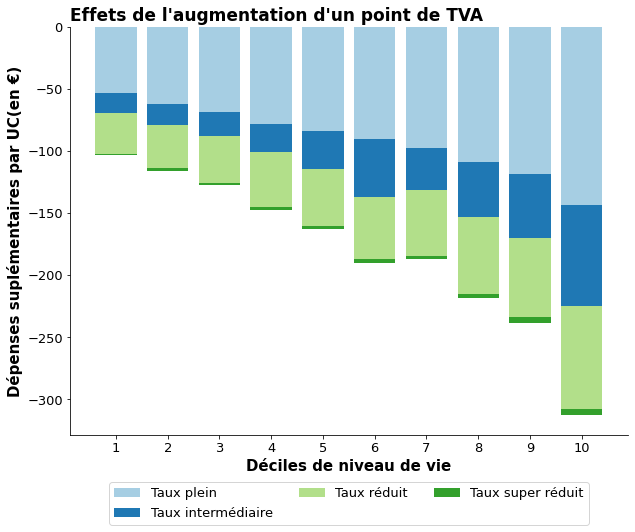

In [29]:
stacked_bar_plot(difference_by_decile, 
                 variables = ['depenses_par_uc_tva_taux_{}'.format(taux) for taux in liste_taux],
                 labels = ['Taux plein','Taux intermédiaire','Taux réduit','Taux super réduit'],
                 title = "Effets de l'augmentation d'un point de TVA",
                 xlabel = 'Déciles de niveau de vie' ,
                 ylabel ='Dépenses suplémentaires par UC(en €)',
                 colors = list(sns.color_palette("Paired")),
                 savefig = True,
                 outfile = 'Effet_net_augmentation_TVA.pdf')

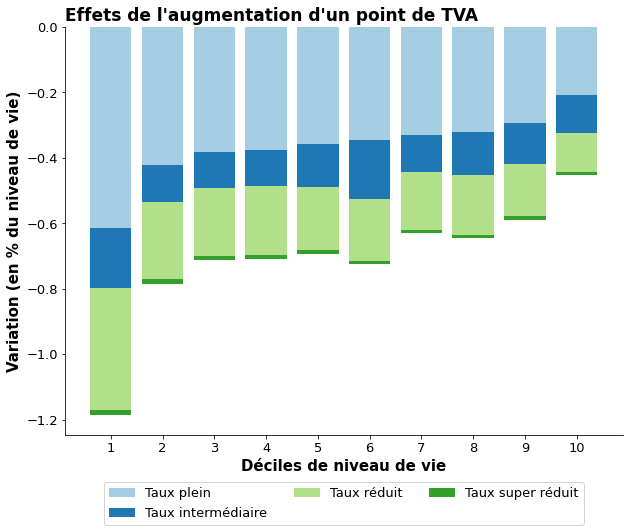

In [30]:
stacked_bar_plot(difference_by_decile, 
                 variables = ['Taux_effort_tva_taux_{}'.format(taux) for taux in liste_taux],
                 labels = ['Taux plein','Taux intermédiaire','Taux réduit','Taux super réduit'],
                 title = "Effets de l'augmentation d'un point de TVA",
                 xlabel = 'Déciles de niveau de vie' ,
                 ylabel ='Variation (en % du niveau de vie)',
                 colors = list(sns.color_palette("Paired")),
                 savefig = True,
                 outfile = 'Taux_effort.pdf')

#### Décomposition actifs / inactifs

In [46]:
difference_by_decile_actifs = df_weighted_average_grouped(dataframe = difference_indiv.loc[difference_indiv['actifs'] == 1], 
                                                   groupe = 'quantile_indiv_niveau_vie', 
                                                   varlist = ['depenses_tot','depenses_tot_par_uc','depenses_totales_par_uc','rev_disponible','niveau_de_vie'] +
                                                   ['depenses_par_uc_tva_taux_{}'.format(taux) for taux in liste_taux]
                                                    )
difference_by_decile_actifs['taux_epargne_actifs'] = 1 - difference_by_decile_actifs['depenses_tot'] / difference_by_decile_actifs['rev_disponible']

In [47]:
difference_by_decile_actifs[['taux_epargne_actifs']]

,taux_epargne_actifs
quantile_indiv_niveau_vie,
1,-0.661274
2,-0.134282
3,-0.061084
4,-0.035895
5,0.000139
6,-0.062194
7,0.098574
8,0.095612
9,0.175287


In [58]:
for taux in liste_taux:
   difference_by_decile_actifs['Taux_effort_tva_taux_{}'.format(taux)] = difference_by_decile_actifs['depenses_par_uc_tva_taux_{}'.format(taux)] / difference_by_decile_actifs['niveau_de_vie'] * 100
difference_by_decile_actifs['Taux_effort_total'] = difference_by_decile_actifs['depenses_totales_par_uc'] / difference_by_decile_actifs['niveau_de_vie'] * 100

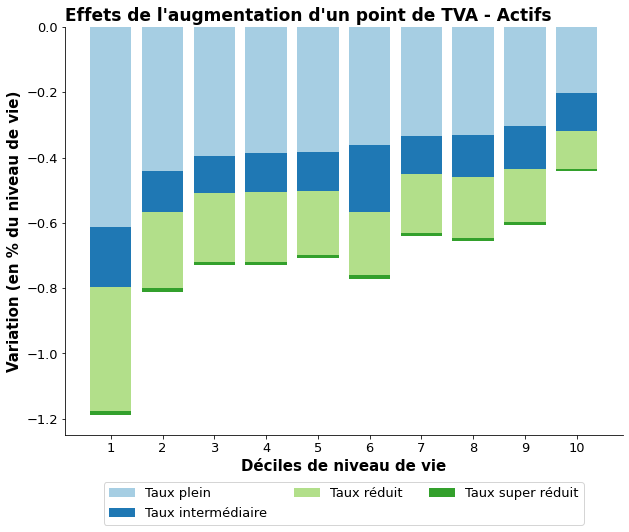

In [59]:
stacked_bar_plot(difference_by_decile_actifs, 
                 variables = ['Taux_effort_tva_taux_{}'.format(taux) for taux in liste_taux],
                 labels = ['Taux plein','Taux intermédiaire','Taux réduit','Taux super réduit'],
                 title = "Effets de l'augmentation d'un point de TVA - Actifs",
                 xlabel = 'Déciles de niveau de vie' ,
                 ylabel ='Variation (en % du niveau de vie)',
                 colors = list(sns.color_palette("Paired")),
                 savefig = True,
                 outfile = 'Taux_effort_actifs_only.pdf')

In [48]:
difference_by_decile_not_actifs = df_weighted_average_grouped(dataframe = difference_indiv.loc[difference_indiv['actifs'] == 0], 
                                                   groupe = 'quantile_indiv_niveau_vie', 
                                                   varlist = ['depenses_tot','depenses_tot_par_uc','depenses_totales_par_uc','rev_disponible','niveau_de_vie'] +
                                                   ['depenses_par_uc_tva_taux_{}'.format(taux) for taux in liste_taux],
                                                    )
difference_by_decile_not_actifs['taux_epargne_inactifs'] = 1 - difference_by_decile_not_actifs['depenses_tot'] / difference_by_decile_not_actifs['rev_disponible']

In [49]:
difference_by_decile_not_actifs[['taux_epargne_inactifs']]

,taux_epargne_inactifs
quantile_indiv_niveau_vie,
1,-0.687910
2,-0.059006
3,0.013932
4,-0.040210
5,0.037933
6,0.125424
7,0.134970
8,0.133863
9,0.277857


In [53]:
for taux in liste_taux:
   difference_by_decile_not_actifs['Taux_effort_tva_taux_{}'.format(taux)] = difference_by_decile_not_actifs['depenses_par_uc_tva_taux_{}'.format(taux)] / difference_by_decile_not_actifs['niveau_de_vie'] * 100
difference_by_decile_not_actifs['Taux_effort_total'] = difference_by_decile_not_actifs['depenses_totales_par_uc'] / difference_by_decile_not_actifs['niveau_de_vie'] * 100

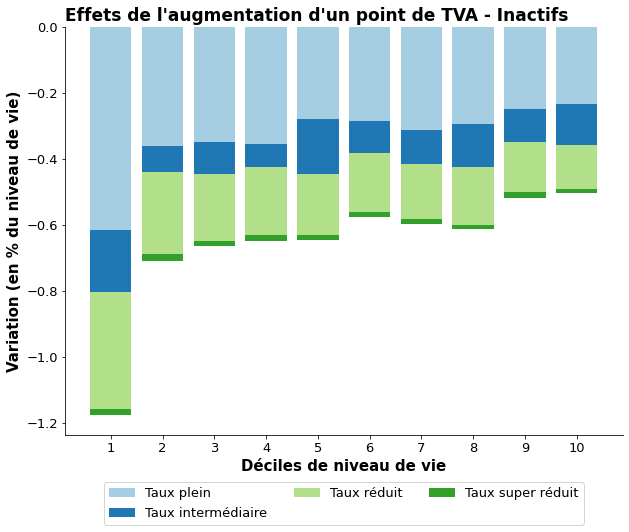

In [54]:
stacked_bar_plot(difference_by_decile_not_actifs, 
                 variables = ['Taux_effort_tva_taux_{}'.format(taux) for taux in liste_taux],
                 labels = ['Taux plein','Taux intermédiaire','Taux réduit','Taux super réduit'],
                 title = "Effets de l'augmentation d'un point de TVA - Inactifs",
                 xlabel = 'Déciles de niveau de vie' ,
                 ylabel ='Variation (en % du niveau de vie)',
                 colors = list(sns.color_palette("Paired")),
                 savefig = True,
                 outfile = 'Taux_effort_not_actifs.pdf')

In [55]:
from openfisca_france_indirect_taxation.projects.TVA_Herve_IPP.Utils import double_stacked_bar_plot

In [56]:
difference_by_decile_not_actifs

,depenses_tot,depenses_tot_par_uc,depenses_totales_par_uc,rev_disponible,niveau_de_vie,depenses_par_uc_tva_taux_plein,depenses_par_uc_tva_taux_intermediaire,depenses_par_uc_tva_taux_reduit,depenses_par_uc_tva_taux_super_reduit,taux_epargne_inactifs,Taux_effort_tva_taux_plein,Taux_effort_tva_taux_intermediaire,Taux_effort_tva_taux_reduit,Taux_effort_tva_taux_super_reduit,Taux_effort_total
quantile_indiv_niveau_vie,,,,,,,,,,,,,,,
1,21404.856012,14862.073549,-96.706903,12681.278076,8211.276542,-50.629498,-15.319525,-29.222708,-1.535150,-0.687910,-0.616585,-0.186567,-0.355885,-0.018696,-1.177733
2,21536.323757,16142.149873,-105.104092,20336.358193,14822.664455,-53.499709,-11.837419,-36.754674,-3.012280,-0.059006,-0.360932,-0.079860,-0.247963,-0.020322,-0.709077
3,23319.903007,18220.856860,-119.295993,23649.394208,17953.877365,-62.716593,-17.211576,-36.692707,-2.675114,0.013932,-0.349321,-0.095866,-0.204372,-0.014900,-0.664458
4,28408.767187,21431.197848,-134.605003,27310.605343,20773.598875,-73.530066,-14.999028,-42.670319,-3.405628,-0.040210,-0.353959,-0.072202,-0.205406,-0.016394,-0.647962
5,30098.540841,22392.808254,-151.937404,31285.280952,23467.546821,-65.586606,-38.900573,-43.518804,-3.931302,0.037933,-0.279478,-0.165763,-0.185442,-0.016752,-0.647436
6,30947.815937,22839.128617,-150.848241,35386.080754,26134.141374,-74.602508,-25.117585,-47.213606,-3.914561,0.125424,-0.285460,-0.096110,-0.180659,-0.014979,-0.577208
7,34849.443268,25526.500430,-177.478170,40286.989071,29759.175296,-92.608827,-31.174770,-49.888039,-3.806533,0.134970,-0.311194,-0.104757,-0.167639,-0.012791,-0.596381
8,40512.049944,28855.327756,-207.314264,46773.243242,33806.657844,-99.063966,-44.836836,-58.981074,-4.432356,0.133863,-0.293031,-0.132627,-0.174466,-0.013111,-0.613235
9,40169.627168,28836.662339,-208.468981,55625.558151,40290.791106,-99.728939,-40.622335,-61.170193,-6.947426,0.277857,-0.247523,-0.100823,-0.151822,-0.017243,-0.517411


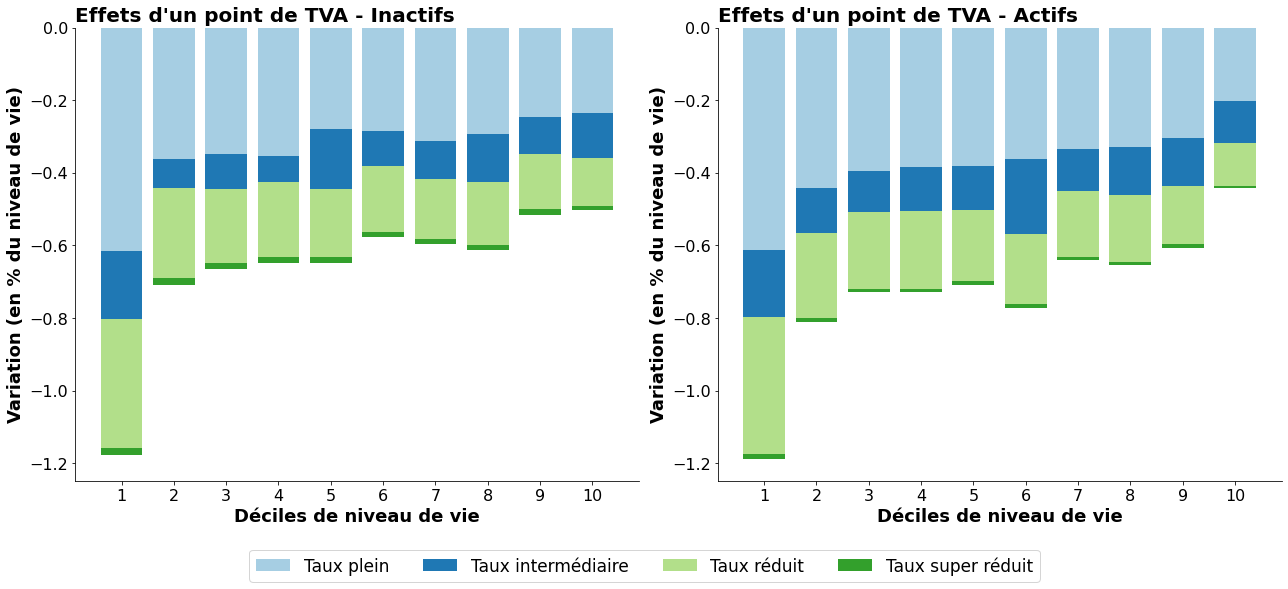

In [60]:
double_stacked_bar_plot(difference_by_decile_not_actifs,
                        difference_by_decile_actifs, 
                        variables = ['Taux_effort_tva_taux_{}'.format(taux) for taux in liste_taux],
                        labels = ['Taux plein','Taux intermédiaire','Taux réduit','Taux super réduit'],
                        title1 = "Effets d'un point de TVA - Inactifs",
                        title2 = "Effets d'un point de TVA - Actifs",
                        xlabel = 'Déciles de niveau de vie' ,
                        ylabel = 'Variation (en % du niveau de vie)',
                        colors = list(sns.color_palette("Paired")),
                        savefig = True,
                        outfile = 'Taux_effort_actifs_not_actifs.pdf')

In [51]:
output_data_path = 'C:/Users/veve1/OneDrive/Documents/IPP/Budget 2026 TVA/Figures/Data/'

In [61]:
output_data_path = 'C:/Users/veve1/OneDrive/Documents/IPP/Budget 2026 TVA/Figures/Data/'
columns_list = ['Taux_effort_total'] + ['Taux_effort_tva_taux_{}'.format(taux) for taux in liste_taux]
to_graph_all = difference_by_decile[columns_list] 
to_graph_all.to_csv(os.path.join(output_data_path,'to_graph_all.csv'), sep = ',', index = True)

# Actifs en emploi uniquement
to_graph_actifs_only = difference_by_decile_actifs[columns_list]
to_graph_actifs_only.to_csv(os.path.join(output_data_path,'to_graph_actifs_only.csv'), sep = ',', index = True)

# Inactifs sans emploi
to_graph_not_actifs = difference_by_decile_not_actifs[columns_list]
to_graph_not_actifs.to_csv(os.path.join(output_data_path,'to_graph_not_actifs.csv'), sep = ',', index = True)

## Boostrap

In [ ]:
# Chat gpt
import numpy as np
import pandas as pd

def bootstrap_weighted_mean_by_decile(df, value_col, weight_col='pondmen', decile_col='niveau_de_vie_decile', B=1000):
    results = {}

    for decile in sorted(df[decile_col].unique()):
        group = df[df[decile_col] == decile]
        means = []

        # Normalize weights for resampling
        weights = group[weight_col].values
        weights = weights / weights.sum()
        data = group[value_col].values

        for _ in range(B):
            sample = np.random.choice(data, size=len(data), replace=True, p=weights)
            mean = np.average(sample)
            means.append(mean)

        means = np.array(means)
        results[decile] = {
            'mean': means.mean(),
            'ci_lower': np.percentile(means, 2.5),
            'ci_upper': np.percentile(means, 97.5)
        }

    return pd.DataFrame(results).T  # Transpose for decile as rows

### Analyse par vingtième de niveau de vie

In [41]:
difference_indiv['vingtieme_indiv_niveau_vie'] = weighted_quantiles(difference_indiv['niveau_de_vie'], labels = np.arange(1,21), weights = difference_indiv['pondmen'], return_quantiles=False)
difference_indiv['vingtieme_indiv_niveau_vie'] = difference_indiv['vingtieme_indiv_niveau_vie'].astype(int)

In [42]:
liste_taux = ['plein','intermediaire', 'reduit', 'super_reduit']
difference_by_vingtieme = df_weighted_average_grouped(dataframe = difference_indiv, 
                                                   groupe = 'vingtieme_indiv_niveau_vie', 
                                                   varlist = ['depenses_tot','depenses_totales','niveau_de_vie','rev_disponible','ocde10'] +
                                                   ['depenses_tva_taux_{}'.format(taux) for taux in liste_taux]
                                                    )
for taux in liste_taux:
   difference_by_vingtieme['Taux_effort_tva_taux_{}'.format(taux)] = difference_by_vingtieme['depenses_tva_taux_{}'.format(taux)] / difference_by_vingtieme['rev_disponible'] * 100
difference_by_vingtieme['Taux_effort_total'] = difference_by_vingtieme['depenses_totales'] / difference_by_vingtieme['rev_disponible'] * 100

KeyError: 'rev_disponible'

In [ ]:
difference_by_vingtieme

,depenses_tot,depenses_totales,niveau_de_vie,rev_disponible,ocde10,depenses_tva_taux_plein,depenses_tva_taux_intermediaire,depenses_tva_taux_reduit,depenses_tva_taux_super_reduit,Taux_effort_tva_taux_plein,Taux_effort_tva_taux_intermediaire,Taux_effort_tva_taux_reduit,Taux_effort_tva_taux_super_reduit,Taux_effort_total
vingtieme_indiv_niveau_vie,,,,,,,,,,,,,,
1,30447.749859,-205.645707,9714.865774,17951.582571,1.737600,-105.458285,-31.230198,-66.707550,-2.249701,-0.587460,-0.173969,-0.371597,-0.012532,-1.145558
2,33554.970420,-229.568854,15727.373460,31543.518472,2.002623,-126.195949,-29.690278,-70.827707,-2.854763,-0.400069,-0.094125,-0.224540,-0.009050,-0.727785
3,37692.613209,-264.654903,18534.013447,36968.648502,1.993161,-144.520686,-33.120223,-82.766804,-4.247041,-0.390928,-0.089590,-0.223884,-0.011488,-0.715890
4,36748.903747,-253.020016,20937.682493,39341.852948,1.876755,-136.174979,-34.055576,-78.704871,-4.084527,-0.346133,-0.086563,-0.200054,-0.010382,-0.643132
5,38835.764824,-262.765215,22896.662390,42159.993242,1.840678,-145.971577,-33.058312,-80.289254,-3.446051,-0.346232,-0.078412,-0.190439,-0.008174,-0.623257
6,41540.282636,-285.751925,24924.124212,45756.181241,1.834260,-153.983350,-43.151025,-84.699318,-3.918326,-0.336530,-0.094306,-0.185110,-0.008563,-0.624510
7,46340.903982,-325.240456,26765.196399,49575.521380,1.852274,-173.481527,-50.470127,-96.297101,-4.991903,-0.349934,-0.101805,-0.194243,-0.010069,-0.656050
8,44348.923956,-303.891393,28511.509437,51325.293325,1.798922,-167.267381,-39.958867,-92.635403,-4.029853,-0.325897,-0.077854,-0.180487,-0.007852,-0.592089
9,47155.404315,-330.774472,30267.822047,54319.179598,1.794109,-173.304981,-60.317138,-92.280993,-4.871363,-0.319049,-0.111042,-0.169887,-0.008968,-0.608946


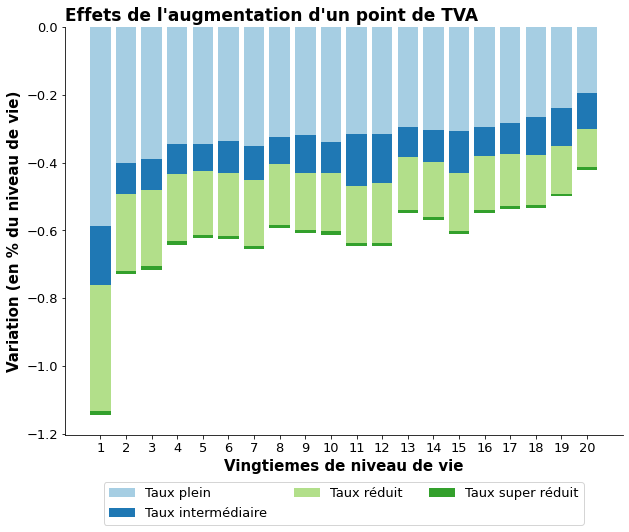

In [ ]:
stacked_bar_plot(difference_by_vingtieme, 
                 variables = ['Taux_effort_tva_taux_{}'.format(taux) for taux in liste_taux],
                 labels = ['Taux plein','Taux intermédiaire','Taux réduit','Taux super réduit'],
                 title = "Effets de l'augmentation d'un point de TVA",
                 xlabel = 'Vingtiemes de niveau de vie' ,
                 ylabel ='Variation (en % du niveau de vie)',
                 colors = list(sns.color_palette("Paired")),
                 savefig = False,
                 outfile = '')